### Model inspired by:

- [1] Offshore Pipelaying Dynamics. Gullik Anthon Jensen
- [2] A nonlinear PDE formulation for offshore vessel pipeline installation. Gullik A. Jensen et al
- [3] Modeling and Control of Offshore Pipelay Operations Based on a Finite Strain Pipe Model. Gullik A. Jensen

### Implementation aspects:

- This implementation is more like pseudo steady-state finite difference method rather than fully dynamic FEM (i.e. the model can be applied to normal dynamic pipelay condition as a rough estimate)

In [1]:
import numpy as np
import inspect
import matplotlib.pyplot as plt
import scipy
from datetime import datetime
from scipy.optimize import root
from scipy.integrate import solve_ivp
from scipy import interpolate

In [2]:
import sys

In [3]:
sys.path.insert(0, "../../../miscellaneous/Ocean_Intella_1/PythonVehicleSimulator-master/src/python_vehicle_simulator")
sys.path.insert(0, "../../../miscellaneous/Ocean_Intella_1/PythonVehicleSimulator-master/src")

In [4]:
from python_vehicle_simulator.vehicles import *
from python_vehicle_simulator.lib import *
from python_vehicle_simulator.lib.gnc import ssa

### Modelling data:

In [5]:
mp = 59.1       #  (submerged pipe weight) [kg/m]
N = 12       # number of modelling nodes

In [6]:
mi = [mp for i in range(N)]

In [7]:
# Vessel:

# L - the hull length
# Xg - x-center of gravity

L = 168 # [m]
B = 46
H = 13.5
Xg = L/2 # [m]
mn = 39_989_000  # mass of the vessel, [kg]

In [8]:
Fx_0 = 604.76664*1000
Fy_0 = 0.7*Fx_0
LTD = 255.21207

In [9]:
lx, ly, lz = L/2, B/2, H/2

In [10]:
vessel_mass = mn/L # mass over length of the vessel

In [11]:
diag_Jrho0 = 1e2*np.array([1, 1, 2]) # [m^4] 
Jrho0 = np.diag(diag_Jrho0)

In [12]:
qw = 1025 # Water density [kg/m3]
d0 = 0.508 # Outer diameter of pipe, [m]
dI= (508-22.1*2)/1000 # Inner diameter of pipe, [m]

In [13]:
rho_steel=7850 #kg/m^3
rho_steel *= 9.81

In [14]:
Ar=np.pi*((d0/2)**2-(dI/2)**2) 
Iy_ = 1/4*np.pi*rho_steel*((d0/2)**4-(dI/2)**4)
Iz_ = 1/2*np.pi*rho_steel*((d0/2)**4-(dI/2)**4)
J_ = 1/32*np.pi*(d0**4-dI**4)

In [15]:
E = 207e9
G = 79.3e9

In [16]:
h = 40 # water depth

In [17]:
# Fossen book p.181
def vessel_inertia_moment(mn, Xg, L):
    r = 0.25*L
    Ir = mn*r**2
    Iz=mn*Xg**2 + Ir
    return Iz

In [18]:
vessel_inertia = vessel_inertia_moment(mn, Xg, L)

In [19]:
# Underwater current: 
dv1_curr = np.zeros(N)
dv2_curr = np.zeros(N)
dv3_curr = np.zeros(N)

In [20]:
# Constants: 

In [21]:
diag_DT = 1.5*np.array([1, 1, 1])
DT=np.diag(diag_DT)

In [22]:
diag_CT = 1e9*np.array([1, 1, 1 ])  
CT=np.diag(diag_CT)

In [23]:
diag_CR = 1e11*np.array([1, 1, 1])
CR=np.diag(diag_CR)

In [24]:
diag_DR = 1.5*np.array([1, 1, 1])
DR=np.diag(diag_DR)

In [25]:
# for testing:

In [26]:
φ = np.random.rand(N)
θ = np.random.rand(N)
ψ = np.random.rand(N)

In [27]:
φ

array([0.48518666, 0.46272197, 0.32832499, 0.07979884, 0.90492073,
       0.86570392, 0.65834269, 0.6795196 , 0.49692853, 0.65514611,
       0.21183662, 0.68680053])

In [28]:
dφ = np.random.rand(N)
dθ = np.random.rand(N)
dψ = np.random.rand(N)

In [29]:
ddφ = np.random.rand(N)
ddθ = np.random.rand(N)
ddψ = np.random.rand(N)

In [30]:
x = np.random.rand(N)
y = np.random.rand(N)
z = np.random.rand(N)

In [31]:
dx = np.random.rand(N)
dy = np.random.rand(N)
dz = np.random.rand(N)

In [32]:
# integration parameters
tspan = (0., 50)

coefs = [1, 1, 1, 1, 1, 1]
k500 = 6
lift_reduction_factor=1
vessel_motion_calibration_coefficient = 1e3

In [33]:
# Tp=10
# z_acceleration_factor=1e-06

### Main functions:

In [34]:
def Π0(φθψ):
    φ0,θ0,ψ0=φθψ
    return np.array([[np.cos(θ0),0,np.cos(φ0)*np.sin(θ0)],
                  [0,1,-np.sin(φ0)],
                  [-np.sin(θ0),0,np.cos(φ0)*np.cos(θ0)]])

In [35]:
def Π(φ,θ,ψ):
    φθψ=np.stack((φ,θ,ψ), axis=1)
    return np.apply_along_axis(Π0, 1, φθψ)

In [36]:
Π(φ,θ,ψ)

array([[[ 0.98627387,  0.        ,  0.14606114],
        [ 0.        ,  1.        , -0.46637348],
        [-0.16511772,  0.        ,  0.87244594]],

       [[ 0.96092987,  0.        ,  0.24768471],
        [ 0.        ,  1.        , -0.44638549],
        [-0.27679194,  0.        ,  0.85987922]],

       [[ 0.6860125 ,  0.        ,  0.68872466],
        [ 0.        ,  1.        , -0.32245794],
        [-0.72758975,  0.        ,  0.64936832]],

       [[ 0.74173844,  0.        ,  0.66855497],
        [ 0.        ,  1.        , -0.07971417],
        [-0.67068926,  0.        ,  0.73937805]],

       [[ 0.64821264,  0.        ,  0.47038994],
        [ 0.        ,  1.        , -0.78637619],
        [-0.76145937,  0.        ,  0.400432  ]],

       [[ 0.93836715,  0.        ,  0.22401081],
        [ 0.        ,  1.        , -0.76155166],
        [-0.34564011,  0.        ,  0.6081597 ]],

       [[ 0.98876925,  0.        ,  0.11821619],
        [ 0.        ,  1.        , -0.61180675],
        

In [37]:
def w_e(φ,θ,ψ,dφ,dθ,dψ): 
    return np.einsum('ijk,ik->ij', Π(φ,θ,ψ), np.stack((dφ,dθ,dψ), axis=1))

In [38]:
w_e(φ,θ,ψ,dφ,dθ,dψ)

array([[ 0.93120725,  0.89816179, -0.06105406],
       [ 0.60068112,  0.01857395,  0.34796156],
       [ 0.20991374,  0.19240526, -0.16983485],
       [ 1.22794027,  0.43681674,  0.20292866],
       [ 0.38288799, -0.10304919,  0.17649063],
       [ 0.21266677, -0.0414637 ,  0.06568781],
       [ 0.74941834, -0.23921006,  0.54244598],
       [ 0.49921151,  0.43206769, -0.24763503],
       [ 1.1277371 ,  0.52113705, -0.19079734],
       [ 0.92085534, -0.06085152,  0.13377899],
       [ 1.00232725,  0.8720673 ,  0.1307376 ],
       [ 0.34266076,  0.16394919,  0.3472326 ]])

In [39]:
def dw_e(φ,θ,ψ,dφ,dθ,dψ,ddφ,ddθ,ddψ):
    return (np.einsum('ijk,ik->ij', Π(φ,θ,ψ), np.stack((ddφ,ddθ,ddψ), axis=1))+
        np.einsum('ijk,ik->ij', Π(dφ,dθ,dψ), np.stack((dφ,dθ,dψ), axis=1)))

In [40]:
dw_e(φ,θ,ψ,dφ,dθ,dψ,ddφ,ddθ,ddψ)

array([[ 1.31969848,  0.95755692, -0.14067809],
       [ 1.00041533, -0.17359007,  0.79919459],
       [ 1.14428134,  0.90225361, -0.01325202],
       [ 2.04528458, -0.13380156,  0.34573098],
       [ 0.98531066,  0.4209124 ,  0.05586714],
       [ 1.0958136 ,  0.58269451,  0.11322705],
       [ 1.08290547,  0.71529493,  0.46535283],
       [ 1.22741285, -0.08952883,  0.20135912],
       [ 1.64033248,  0.74332511,  0.13130616],
       [ 2.12006057,  0.24902798,  0.3418439 ],
       [ 1.12238136,  1.13106959, -0.65598605],
       [ 1.32820346,  0.88556148,  0.58957533]])

In [41]:
def phi(x,y,z): return np.stack((x,y,z), axis=1) 
def theta(φ,θ,ψ): return np.stack((φ,θ,ψ), axis=1) 

In [42]:
phi(x,y,z)

array([[0.19942661, 0.40914015, 0.91262722],
       [0.42621107, 0.85369873, 0.80907423],
       [0.31904741, 0.85770523, 0.41970596],
       [0.59774543, 0.62728018, 0.73236195],
       [0.96303094, 0.04221332, 0.87074977],
       [0.13469171, 0.48111008, 0.87530592],
       [0.94703691, 0.81576424, 0.61172954],
       [0.69572865, 0.8422559 , 0.46747991],
       [0.40342177, 0.60164471, 0.98235759],
       [0.6555039 , 0.58321437, 0.07844603],
       [0.19942664, 0.80658688, 0.69162199],
       [0.38157982, 0.67923949, 0.0590641 ]])

In [43]:
theta(φ,θ,ψ)

array([[0.48518666, 0.16587737, 0.4946441 ],
       [0.46272197, 0.280454  , 0.49455312],
       [0.32832499, 0.81480195, 0.19035533],
       [0.07979884, 0.73513765, 0.60765311],
       [0.90492073, 0.86556153, 0.71719727],
       [0.86570392, 0.35292086, 0.68261198],
       [0.65834269, 0.1500122 , 0.17046173],
       [0.6795196 , 0.51844778, 0.62252156],
       [0.49692853, 0.85550256, 0.96407212],
       [0.65514611, 0.57502126, 0.32312795],
       [0.21183662, 0.30250424, 0.69071056],
       [0.68680053, 0.53092472, 0.21489989]])

In [44]:
def ω(φ,θ,ψ): 
    return np.einsum('ijk,ik->ij', Π(φ,θ,ψ), theta(φ,θ,ψ))

In [45]:
ω(x,y,z)

array([[ 0.53883272,  0.228342  ,  0.74137085],
       [ 0.83536373,  0.51920817,  0.16291254],
       [ 0.51013479,  0.72605934,  0.01939585],
       [ 0.83927264,  0.21512132,  0.13928439],
       [ 0.98315643, -0.6726079 ,  0.45614449],
       [ 0.52079269,  0.36356979,  0.70658443],
       [ 0.90922341,  0.3192305 , -0.4448134 ],
       [ 0.73094411,  0.54262703, -0.28021254],
       [ 0.84396177,  0.21600284,  0.51651179],
       [ 0.58139419,  0.5353969 , -0.30908483],
       [ 0.62740295,  0.66957147,  0.32512196],
       [ 0.33132398,  0.65724477, -0.19705933]])

In [46]:
def Ret(φ,θ,ψ):
    
    def Ret0(arr):
        φ,θ,ψ=arr
        Cφ=np.matrix([[1,0,0],
                      [0,np.cos(φ),-np.sin(φ)],
                      [0,np.sin(φ),np.cos(φ)]])

        Cθ=np.matrix([[np.cos(θ),0,np.sin(θ)],
                      [0,1,0],
                      [-np.sin(θ),0,np.cos(θ)]])

        Cψ=np.matrix([[np.cos(ψ),-np.sin(ψ),0],
                      [np.sin(ψ),np.cos(ψ),0],
                      [0,0,1]])


        return np.array(np.dot(np.dot(Cθ,Cφ),Cψ) )
    
    arr=np.stack((φ,θ,ψ), axis=1)
    return np.apply_along_axis(Ret0, 1, arr)

In [47]:
Ret(φ,θ,ψ)

array([[[ 0.90461325, -0.40042604,  0.14606114],
        [ 0.4199302 ,  0.77855919, -0.46637348],
        [ 0.07303084,  0.48322311,  0.87244594]],

       [[ 0.9044365 , -0.34734263,  0.24768471],
        [ 0.42472576,  0.78762175, -0.44638549],
        [-0.04003316,  0.5089254 ,  0.85987922]],

       [[ 0.71801249,  0.10058029,  0.68872466],
        [ 0.17910105,  0.92948571, -0.32245794],
        [-0.67259265,  0.35488014,  0.64936832]],

       [[ 0.63948454, -0.37959687,  0.66855497],
        [ 0.56912539,  0.81837763, -0.07971417],
        [-0.51687118,  0.43146758,  0.73937805]],

       [[ 0.882098  ,  0.02522731,  0.47038994],
        [ 0.40603024,  0.46556624, -0.78637619],
        [-0.23883583,  0.88465341,  0.400432  ]],

       [[ 0.89415175, -0.38770067,  0.22401081],
        [ 0.40883831,  0.50288199, -0.76155166],
        [ 0.18260309,  0.77252695,  0.6081597 ]],

       [[ 0.98994931, -0.07762281,  0.11821619],
        [ 0.13418442,  0.77954284, -0.61180675],
        

In [48]:
def d_s(func, a, b, c, φ, θ, ψ): 
    
    sig = inspect.signature(func)
    num_args = len(sig.parameters)
    
    if num_args==3:
        fu = func(a, b, c)
    else:
        fu = func(a, b, c, φ, θ, ψ)

    def S(arr):
        a1, a2, a3 = arr[0],arr[1],arr[2]
        return np.array([[0, -a3, a2 ],
                         [a3, 0, -a1],
                        [-a2, a1, 0]])
    
    S0 = np.apply_along_axis(S, 1, ω(φ,θ,ψ))

    
    return np.einsum('ijk,ik->ij',S0, fu).T

In [49]:
d_s(phi,x,y,z,φ, θ, ψ).T

array([[-2.02935876e-01, -4.32566485e-01,  2.38269391e-01],
       [-2.05404887e-01, -3.32194957e-01,  4.58722125e-01],
       [ 4.15087138e-01, -1.86335200e-01,  6.52556790e-02],
       [ 2.54656644e-01, -1.04303272e-01, -1.18510349e-01],
       [ 2.79560414e-01, -1.19153835e+00, -2.51423025e-01],
       [-2.01876987e-01, -8.29285495e-01,  4.86879803e-01],
       [-5.27007435e-04, -3.77449346e-01,  5.04158707e-01],
       [-1.11689920e-02, -3.29732256e-01,  6.10699024e-01],
       [ 2.80217868e-01, -8.75736358e-01,  4.21268350e-01],
       [ 1.12061862e-01, -1.46670877e-01,  1.54036797e-01],
       [-3.60253418e-01, -1.63025949e-01,  2.94002683e-01],
       [ 1.62178955e-01, -1.17963568e-01,  3.08838982e-01]])

In [50]:
d_s(theta, φ, θ, ψ, φ, θ, ψ).T

array([[-0.09035414, -0.10192501,  0.12280683],
       [-0.05382363, -0.14296828,  0.13143462],
       [ 0.23734402, -0.10567845,  0.04297772],
       [ 0.12633297, -0.25124408,  0.28736422],
       [ 0.56413316, -1.02631168,  0.52682872],
       [-0.15485279, -0.55855028,  0.48516686],
       [ 0.00255362, -0.09139923,  0.07057212],
       [ 0.03572163, -0.45980475,  0.34394183],
       [ 0.22711374, -0.84118482,  0.62938908],
       [ 0.20343017, -0.31523941,  0.14852593],
       [-0.06727253, -0.15544188,  0.08870954],
       [ 0.19335921, -0.28577171,  0.08805988]])

In [51]:
def ne(x, y, z, φ, θ, ψ):
    RET = Ret(φ,θ,ψ)
    A = np.einsum('ijk,ikp->ijp',np.einsum('ijk,kp->ijp',RET, CT), np.transpose(RET,(0,2,1))) 
    B = d_s(phi, x, y, z, φ, θ, ψ).T
#     t1=np.einsum('ijk,kp->ijp',RET, np.array([0,0,1]).reshape(3,1)).squeeze()
    return np.einsum('ijk,ik->ij', A, B 
#                      - t1
                    )

In [52]:
ne(x, y, z, φ, θ, ψ)

array([[-2.02935876e+08, -4.32566485e+08,  2.38269391e+08],
       [-2.05404887e+08, -3.32194957e+08,  4.58722125e+08],
       [ 4.15087138e+08, -1.86335200e+08,  6.52556790e+07],
       [ 2.54656644e+08, -1.04303272e+08, -1.18510349e+08],
       [ 2.79560414e+08, -1.19153835e+09, -2.51423025e+08],
       [-2.01876987e+08, -8.29285495e+08,  4.86879803e+08],
       [-5.27007435e+05, -3.77449346e+08,  5.04158707e+08],
       [-1.11689920e+07, -3.29732256e+08,  6.10699024e+08],
       [ 2.80217868e+08, -8.75736358e+08,  4.21268350e+08],
       [ 1.12061862e+08, -1.46670877e+08,  1.54036797e+08],
       [-3.60253418e+08, -1.63025949e+08,  2.94002683e+08],
       [ 1.62178955e+08, -1.17963568e+08,  3.08838982e+08]])

In [53]:
d_s(ne, x, y, z, φ, θ, ψ).T

array([[ 1.36577406e+08, -2.02552113e+08, -2.51399475e+08],
       [ 1.26103461e+08, -3.21199974e+08, -1.76138756e+08],
       [ 2.76851342e+07, -7.11022863e+07, -3.79133314e+08],
       [-4.01013469e+07,  1.55943608e+08, -2.23419332e+08],
       [-5.54668283e+08,  1.19953252e+08, -1.18522238e+09],
       [ 1.48550601e+07, -4.93366472e+08, -8.34174599e+08],
       [ 3.62367578e+07, -3.38359494e+08, -2.53282292e+08],
       [ 1.05366844e+08, -5.07928278e+08, -2.72316622e+08],
       [ 3.25001772e+08, -3.56174510e+08, -9.56602298e+08],
       [ 3.75266635e+07, -1.21984601e+08, -1.43452063e+08],
       [ 1.41039900e+08, -3.28084906e+08, -9.10279804e+06],
       [ 9.77703070e+07, -2.42054410e+08, -1.43796252e+08]])

In [54]:
def me(a, b, c, φ, θ, ψ):
    RET = Ret(φ,θ,ψ)
    A = np.einsum('ijk,ikp->ijp',np.einsum('ijk,kp->ijp', RET, CR), np.transpose(RET,(0,2,1))) 
    return np.einsum('ijk,ik->ij', A, ω(φ,θ,ψ))

In [55]:
me(φ, θ, ψ, φ, θ, ψ)

array([[ 5.50775201e+10, -6.48115188e+09,  3.51437322e+10],
       [ 5.67136610e+10,  5.96926687e+09,  2.97178242e+10],
       [ 3.56337454e+10,  7.53420365e+10, -1.15275178e+10],
       [ 4.65439370e+10,  6.86699081e+10,  3.95765155e+10],
       [ 9.23943434e+10,  3.01574675e+10, -4.01871636e+10],
       [ 9.65260582e+10, -1.66923430e+10,  1.15915095e+10],
       [ 6.71100349e+10,  4.57225676e+09,  3.49327065e+09],
       [ 8.30182049e+10,  1.27243147e+10,  8.38849654e+09],
       [ 9.65659719e+10,  3.95902563e+10,  1.80671444e+10],
       [ 6.89135831e+10,  3.78147437e+10, -1.41282011e+10],
       [ 4.03388872e+10,  1.57278329e+10,  5.81500370e+10],
       [ 6.76395855e+10,  3.94663929e+10, -2.04447014e+10]])

In [56]:
d_s(me, φ, θ, ψ, φ, θ, ψ).T

array([[ 9.53674316e-07,  4.32387774e-06, -4.76837158e-07],
       [ 7.15255737e-07, -3.43279511e-06, -4.76837158e-07],
       [ 0.00000000e+00,  5.00501611e-07,  7.62939453e-06],
       [ 7.62939453e-06, -4.93468333e-06, -3.81469727e-06],
       [ 5.72204590e-06, -1.95342557e-05, -3.81469727e-06],
       [-2.14576721e-06, -1.19456855e-05,  1.90734863e-06],
       [ 2.38418579e-07, -2.65437238e-06, -9.53674316e-07],
       [-2.38418579e-07,  2.32296828e-06, -1.90734863e-06],
       [-1.90734863e-06,  3.93952558e-06,  0.00000000e+00],
       [-1.90734863e-06,  1.68971993e-06,  0.00000000e+00],
       [ 0.00000000e+00,  4.40023596e-08, -9.53674316e-07],
       [-2.86102295e-06,  9.77449479e-06,  7.62939453e-06]])

In [57]:
def fD(dx,dy,dz): 
    
    A=np.vstack([np.abs(dx-dv1_curr)*dx-(dv1_curr),
                 ((dy-dv2_curr)**2+(dz-dv3_curr)**2)**0.5*(dy-dv2_curr),
                 ((dy-dv2_curr)**2+(dz-dv3_curr)**2)**0.5*(dz-dv3_curr)])
    
    return 1/2*d0*qw*np.dot(DT, A)*9.81

In [58]:
fD(dx,dy,dz).T

array([[6.68179643e+02, 1.45875462e+03, 3.70516547e+02],
       [6.20544236e+02, 6.99562039e+02, 8.53627917e+02],
       [3.19641493e+00, 4.27049845e+01, 2.30101679e+02],
       [1.52496265e+02, 3.67673094e+02, 1.32503343e+03],
       [6.70617947e+02, 1.82256950e+03, 2.24553760e+03],
       [3.10892027e+03, 1.77442038e+03, 1.01724759e+03],
       [6.77312833e+02, 4.46435420e+03, 3.54901508e+03],
       [1.13463121e+03, 8.92816662e+02, 2.14893024e+03],
       [2.30929834e+03, 2.78940901e+03, 2.37427310e+03],
       [3.44139778e+03, 3.70885622e+03, 3.95594959e+03],
       [1.38791836e+02, 1.63683632e+03, 8.47276000e+02],
       [5.60821391e+02, 1.68832222e+03, 1.29502903e+03]])

In [59]:
fg_e = lift_reduction_factor*np.array([[0,0,(mp-qw*Ar)*9.81] for x in range(N)])          

In [60]:
fg_e

array([[  0.        ,   0.        , 240.55063414],
       [  0.        ,   0.        , 240.55063414],
       [  0.        ,   0.        , 240.55063414],
       [  0.        ,   0.        , 240.55063414],
       [  0.        ,   0.        , 240.55063414],
       [  0.        ,   0.        , 240.55063414],
       [  0.        ,   0.        , 240.55063414],
       [  0.        ,   0.        , 240.55063414],
       [  0.        ,   0.        , 240.55063414],
       [  0.        ,   0.        , 240.55063414],
       [  0.        ,   0.        , 240.55063414],
       [  0.        ,   0.        , 240.55063414]])

In [61]:
def sigma(x,y,z):
    e3 = np.array([[0,0,1] for x in range(N)])
    
    k = phi(x,y,z)*e3+d0/2
    
    fg_e2 = np.linalg.norm(fg_e, ord=2)
    k0=np.zeros(k.shape)
    
    for i in range(k.shape[0]):
        for j in range(k.shape[1]):
            if k[i][j]<0:
                k0[i][j]=0
            elif 0<=k[i][j]<=d0/20:
                k0[i][j]=(fg_e2*10*k[i][j]**2)/((d0/8-d0/40)*d0)
            else:
                k0[i][j]=(fg_e2*(k[i][j]-d0/40))/(d0/8-d0/40)
                
    return k0         

In [62]:
sigma(x,y,z)

array([[ 3958.1362412 ,  3958.1362412 , 18928.30974246],
       [ 3958.1362412 ,  3958.1362412 , 17229.69039335],
       [ 3958.1362412 ,  3958.1362412 , 10842.73366541],
       [ 3958.1362412 ,  3958.1362412 , 15971.34963355],
       [ 3958.1362412 ,  3958.1362412 , 18241.3779607 ],
       [ 3958.1362412 ,  3958.1362412 , 18316.11414093],
       [ 3958.1362412 ,  3958.1362412 , 13992.56999605],
       [ 3958.1362412 ,  3958.1362412 , 11626.38808913],
       [ 3958.1362412 ,  3958.1362412 , 20072.12366241],
       [ 3958.1362412 ,  3958.1362412 ,  5244.91642797],
       [ 3958.1362412 ,  3958.1362412 , 15303.07646737],
       [ 3958.1362412 ,  3958.1362412 ,  4926.98731709]])

In [63]:
def ne_hat(x,y,z,dx,dy,dz):
    return -fg_e.T - fD(dx,dy,dz) #- sigma(x,y,z).T

In [64]:
ne_hat(x,y,z,dx,dy,dz).T

array([[-6.68179643e+02, -1.45875462e+03, -6.11067181e+02],
       [-6.20544236e+02, -6.99562039e+02, -1.09417855e+03],
       [-3.19641493e+00, -4.27049845e+01, -4.70652313e+02],
       [-1.52496265e+02, -3.67673094e+02, -1.56558406e+03],
       [-6.70617947e+02, -1.82256950e+03, -2.48608824e+03],
       [-3.10892027e+03, -1.77442038e+03, -1.25779822e+03],
       [-6.77312833e+02, -4.46435420e+03, -3.78956571e+03],
       [-1.13463121e+03, -8.92816662e+02, -2.38948087e+03],
       [-2.30929834e+03, -2.78940901e+03, -2.61482373e+03],
       [-3.44139778e+03, -3.70885622e+03, -4.19650022e+03],
       [-1.38791836e+02, -1.63683632e+03, -1.08782663e+03],
       [-5.60821391e+02, -1.68832222e+03, -1.53557966e+03]])

In [65]:
def Jrho(Ret,Jrho0): 
    ans=  Ret @ Jrho0 @ Ret
    return ans

In [66]:
RET = Ret(φ, θ, ψ)

In [67]:
Jrho(RET,Jrho0)

array([[[  67.15080763,  -53.28258371,   57.37378351],
        [  63.86956335,   -1.27214699, -111.55351729],
        [  39.64155688,  119.01464289,  130.76283616]],

       [[  65.06488088,  -33.56178851,   80.5021687 ],
        [  75.44011667,    1.84688388, -101.40600504],
        [  11.10989143,  128.99747027,  124.16920471]],

       [[ -39.29063157,   65.45352663,  135.6551953 ],
        [  72.88343416,   65.30898858,  -59.51566821],
        [-129.28912355,   72.31022961,   26.56933588]],

       [[ -49.82113226,    2.35196838,  144.64195556],
        [  91.2110288 ,   38.49155685,   19.73774932],
        [ -84.92983847,  118.73414249,   71.34089422]],

       [[  56.36479916,   86.62620676,   77.18102495],
        [  92.28220642, -116.43457809,  -80.48980552],
        [  -4.27555882,  111.43266578,  -48.73247694]],

       [[  72.28105875,  -19.55221383,   76.80224479],
        [  29.30375469, -108.22549638, -121.76764747],
        [  70.12171664,  125.73340698,   19.23023208]],

### Static solution

In [68]:
def catenary(x,Ws,Fh):
    return (Fh/Ws)*(np.cosh(x*Ws/Fh)-1)

In [69]:
pipe_weight_per_unit_length = mi #  (submerged) [kg/m]  # 113.07 - not submerged

In [70]:
# Fx_0 = 82945396 
# Fy_0 = 82945396 

In [71]:
Ws = np.array(pipe_weight_per_unit_length)*9.81 # [N/m]

In [72]:
horizontal_length=2*(Fx_0/Ws[0])*(np.sinh(LTD*Ws[0]/(2*Fx_0)))

In [73]:
delta_x=horizontal_length/(N-1)

In [74]:
x0=[i*delta_x for i in range(N)]
z0=[]

for i in range(len(x0)):
    z0.append(catenary(x0[i],Ws[0],Fx_0))

length_p=[]
for i in range(1,len(z0)):
    length_p.append(np.sqrt((x0[i]-x0[i-1])**2+(z0[i]-z0[i-1])**2))

In [75]:
cum_len = 0
length_p1=[0]
for i in range(len(length_p)):
    cum_len+=length_p[i]
    length_p1.append(cum_len)

In [76]:
length_p1

[0,
 23.26045397959677,
 46.53247371134786,
 69.82763069727322,
 93.15750794198678,
 116.53370571115184,
 139.96784729853016,
 163.471584804496,
 187.05660492889174,
 210.73463478110844,
 234.5174477102832,
 258.41686915851545]

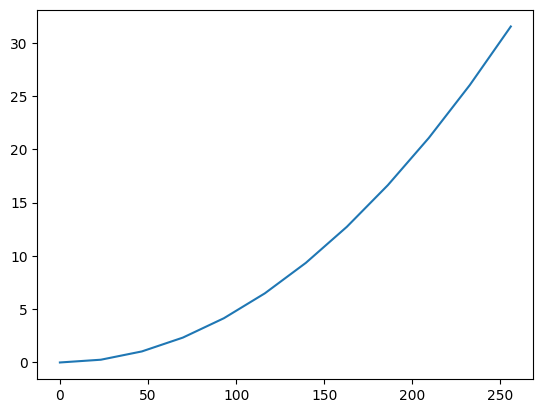

In [77]:
plt.plot(x0, z0)
plt.show()

In [78]:
q0=np.zeros(12*N)

In [79]:
for j in range(1,12):
    if j==1:
        q0[(j-1)*N:j*N]=x0
    elif j==5:
        q0[(j-1)*N:j*N]=z0

In [80]:
def static_func(Q): 
    t=0

    x,y,z=Q[0:N],Q[2*N:3*N],Q[4*N:5*N]
    dx,dy,dz=Q[1*N:2*N],Q[3*N:4*N],Q[5*N:6*N]
    φ,θ,ψ=Q[6*N:7*N],Q[8*N:9*N],Q[10*N:11*N]
    dφ,dθ,dψ=Q[7*N:8*N],Q[9*N:10*N],Q[11*N:12*N]
    
    RET = Ret(φ,θ,ψ)

    η = [x[-1],y[-1],z[-1],φ[-1],θ[-1],ψ[-1]]

    tau_force = np.array([-Fx_0,Fy_0,0,0,0,0])

    Z0 = tau_force[:3]    
    Z1 = d_s(ne, x, y, z, φ, θ, ψ).T
    Z2 = ne_hat(x, y, z, dx, dy, dz).T


    Z = (Z1 + Z2 - Z0)


############################################################
    ddx,ddy, ddz = (Z/Ws[0]).T
############################################################
    
    C0 = np.einsum('ijk,kp->ijp', Π(φ,θ,ψ), tau_force[3:].reshape(3,1))
    C1 = d_s(me, φ, θ, ψ, φ, θ, ψ)
    C = (C1.T - C0.squeeze())
 
    A0 = Jrho(RET,Jrho0)
    A_fin = np.einsum('ijk,ikr->ijr',A0, Π(φ,θ,ψ))

    B = np.einsum('ijk,ik->ij', Π(dφ,dθ,dψ), np.stack((dφ,dθ,dψ), axis=1))
    
    D = w_e(φ,θ,ψ,dφ,dθ,dψ)
    
    G = np.cross(d_s(phi,x,y,z,φ, θ, ψ).T, ne(x, y, z, φ, θ, ψ))
    L = np.einsum('ijk,ik->ij',RET, (DR@D.T).T) 
    
    H = np.cross(D,np.einsum('ijk,ik->ij', A0, D))

#############################################
    ddφ,ddθ,ddψ = np.linalg.solve(A_fin, C + G - L - H - np.einsum('ijk,ik->ij',A0, B)).T
#############################################

    ans=np.concatenate([dx, ddx, dy, ddy, dz, ddz, dφ, ddφ, dθ, ddθ, dψ, ddψ], axis=0)

    return ans

In [81]:
root_ = root(static_func, q0, method='df-sane')

In [82]:
root_

 message: too many function evaluations required
 success: False
     fun: [ 1.259e+01  1.259e+01 ...  0.000e+00  0.000e+00]
       x: [-5.142e+02 -4.909e+02 ...  0.000e+00  0.000e+00]
     nit: 291
    nfev: 1000
  method: df-sane

In [83]:
x0_, z0_=root_.x[:N],root_.x[4*N:5*N]

In [84]:
# q0 = root_.x                                            # start from static solution

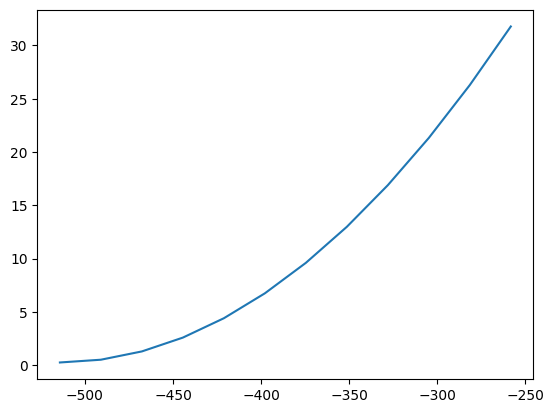

In [85]:
plt.plot(x0_, z0_)
plt.show()

### Finite Element Model of the Space Frame Element

In [86]:
def PlaneTrussElementLength(x1,y1,z1,x2,y2,z2):
    return np.sqrt((x2-x1)*(x2-x1) + (y2-y1)*(y2-y1)+(z2-z1)*(z2-z1))

In [87]:
def SpaceFrameElementStiffness(E,G,A,Iy,Iz,J,x1,y1,z1,x2,y2,z2):
    L = PlaneTrussElementLength(x1,y1,z1,x2,y2,z2)
    w1 = E*A/L
    w2 = 12*E*Iz/(L*L*L)
    w3 = 6*E*Iz/(L*L)
    w4 = 4*E*Iz/L
    w5 = 2*E*Iz/L
    w6 = 12*E*Iy/(L*L*L)
    w7 = 6*E*Iy/(L*L)
    w8 = 4*E*Iy/L
    w9 = 2*E*Iy/L
    w10 = G*J/L

    kprime = np.array([[w1, 0, 0, 0, 0, 0, -w1, 0, 0, 0, 0, 0],
                        [0, w2, 0, 0, 0, w3, 0, -w2, 0, 0, 0, w3],
                        [0, 0, w6, 0, -w7, 0, 0, 0, -w6, 0, -w7, 0],
                        [0, 0, 0, w10, 0, 0, 0, 0, 0, -w10, 0, 0],
                        [0, 0, -w7, 0, w8, 0, 0, 0, w7, 0, w9, 0],
                        [0, w3, 0, 0, 0, w4, 0, -w3, 0, 0, 0, w5],
                        [-w1, 0, 0, 0, 0, 0, w1, 0, 0, 0, 0, 0],
                        [0, -w2, 0, 0, 0, -w3, 0, w2, 0, 0, 0, -w3],
                        [0, 0, -w6, 0, w7, 0, 0, 0, w6, 0, w7, 0],
                        [0, 0, 0, -w10, 0, 0, 0, 0, 0, w10, 0, 0],
                        [0, 0, -w7, 0, w9, 0, 0, 0, w7, 0, w8, 0],
                        [0, w3, 0, 0, 0, w5, 0, -w3, 0, 0, 0, w4]])


    if x1 == x2 and y1 == y2:
        if z2 > z1:
            Lambda = np.array([[0, 0, 1], [0, 1, 0], [-1, 0, 0]])
        else:
            Lambda = np.array([[0, 0, -1], [0, 1, 0], [1, 0, 0]])
    else:
        CXx = (x2-x1)/L
        CYx = (y2-y1)/L
        CZx = (z2-z1)/L
        D = np.sqrt(CXx*CXx + CYx*CYx)
        CXy = -CYx/D
        CYy = CXx/D
        CZy = 0
        CXz = -CXx*CZx/D
        CYz = -CYx*CZx/D
        CZz = D
        Lambda = np.array([[CXx, CYx, CZx], [CXy, CYy, CZy], [CXz, CYz, CZz]])


    R = np.array([np.concatenate((np.concatenate((Lambda,np.zeros((3,3)),np.zeros((3,3)),np.zeros((3,3))),axis=1),
        np.concatenate((np.zeros((3,3)), Lambda, np.zeros((3,3)), np.zeros((3,3))),axis=1) ,
        np.concatenate((np.zeros((3,3)), np.zeros((3,3)), Lambda, np.zeros((3,3))),axis=1),
        np.concatenate((np.zeros((3,3)), np.zeros((3,3)), np.zeros((3,3)), Lambda),axis=1)))])[0]
    return np.dot(np.dot(R.T,kprime),R)

In [88]:
def SpaceFrameAssemble(K,k,i,j):
    K[6*i,6*i] = K[6*i,6*i] + k[0,0]
    K[6*i,6*i+1] = K[6*i,6*i+1] + k[0,1]
    K[6*i,6*i+2] = K[6*i,6*i+2] + k[0,2]
    K[6*i,6*i+3] = K[6*i,6*i+3] + k[0,3]
    K[6*i,6*i+4] = K[6*i,6*i+4] + k[0,4]
    K[6*i,6*i+5] = K[6*i,6*i+5] + k[0,5]
    K[6*i,6*j] = K[6*i,6*j] + k[0,6]
    K[6*i,6*j+1] = K[6*i,6*j+1] + k[0,7]
    K[6*i,6*j+2] = K[6*i,6*j+2] + k[0,8]
    K[6*i,6*j+3] = K[6*i,6*j+3] + k[0,9]
    K[6*i,6*j+4] = K[6*i,6*j+4] + k[0,10]
    K[6*i,6*j+5] = K[6*i,6*j+5] + k[0,11]
    K[6*i+1,6*i] = K[6*i+1,6*i] + k[1,0]
    K[6*i+1,6*i+1] = K[6*i+1,6*i+1] + k[1,1]
    K[6*i+1,6*i+2] = K[6*i+1,6*i+2] + k[1,2]
    K[6*i+1,6*i+3] = K[6*i+1,6*i+3] + k[1,3]
    K[6*i+1,6*i+4] = K[6*i+1,6*i+4] + k[1,4]
    K[6*i+1,6*i+5] = K[6*i+1,6*i+5] + k[1,5]
    K[6*i+1,6*j] = K[6*i+1,6*j] + k[1,6]
    K[6*i+1,6*j+1] = K[6*i+1,6*j+1] + k[1,7]
    K[6*i+1,6*j+2] = K[6*i+1,6*j+2] + k[1,8]
    K[6*i+1,6*j+3] = K[6*i+1,6*j+3] + k[1,9]
    K[6*i+1,6*j+4] = K[6*i+1,6*j+4] + k[1,10]
    K[6*i+1,6*j+5] = K[6*i+1,6*j+5] + k[1,11]
    K[6*i+2,6*i]   = K[6*i+2,6*i] + k[2,0]
    K[6*i+2,6*i+1] = K[6*i+2,6*i+1] + k[2,1]
    K[6*i+2,6*i+2] = K[6*i+2,6*i+2] + k[2,2]
    K[6*i+2,6*i+3] = K[6*i+2,6*i+3] + k[2,3]
    K[6*i+2,6*i+4] = K[6*i+2,6*i+4] + k[2,4]
    K[6*i+2,6*i+5] = K[6*i+2,6*i+5] + k[2,5]
    K[6*i+2,6*j]   = K[6*i+2,6*j] + k[2,6]
    K[6*i+2,6*j+1] = K[6*i+2,6*j+1] + k[2,7]
    K[6*i+2,6*j+2] = K[6*i+2,6*j+2] + k[2,8]
    K[6*i+2,6*j+3] = K[6*i+2,6*j+3] + k[2,9]
    K[6*i+2,6*j+4] = K[6*i+2,6*j+4] + k[2,10]
    K[6*i+2,6*j+5] = K[6*i+2,6*j+5] + k[2,11]
    K[6*i+3,6*i] = K[6*i+3,6*i] + k[3,0]
    K[6*i+3,6*i+1] = K[6*i+3,6*i+1] + k[3,1]
    K[6*i+3,6*i+2] = K[6*i+3,6*i+2] + k[3,2]
    K[6*i+3,6*i+3] = K[6*i+3,6*i+3] + k[3,3]
    K[6*i+3,6*i+4] = K[6*i+3,6*i+4] + k[3,4]
    K[6*i+3,6*i+5] = K[6*i+3,6*i+5] + k[3,5]
    K[6*i+3,6*j] = K[6*i+3,6*j] + k[3,6]
    K[6*i+3,6*j+1] = K[6*i+3,6*j+1] + k[3,7]
    K[6*i+3,6*j+2] = K[6*i+3,6*j+2] + k[3,8]
    K[6*i+3,6*j+3] = K[6*i+3,6*j+3] + k[3,9]
    K[6*i+3,6*j+4] = K[6*i+3,6*j+4] + k[3,10]
    K[6*i+3,6*j+5] = K[6*i+3,6*j+5] + k[3,11]
    K[6*i+4,6*i] = K[6*i+4,6*i] + k[4,0]
    K[6*i+4,6*i+1] = K[6*i+4,6*i+1] + k[4,1]
    K[6*i+4,6*i+2] = K[6*i+4,6*i+2] + k[4,2]
    K[6*i+4,6*i+3] = K[6*i+4,6*i+3] + k[4,3]
    K[6*i+4,6*i+4] = K[6*i+4,6*i+4] + k[4,4]
    K[6*i+4,6*i+5] = K[6*i+4,6*i+5] + k[4,5]
    K[6*i+4,6*j] = K[6*i+4,6*j] + k[4,6]
    K[6*i+4,6*j+1] = K[6*i+4,6*j+1] + k[4,7]
    K[6*i+4,6*j+2] = K[6*i+4,6*j+2] + k[4,8]
    K[6*i+4,6*j+3] = K[6*i+4,6*j+3] + k[4,9]
    K[6*i+4,6*j+4] = K[6*i+4,6*j+4] + k[4,10]
    K[6*i+4,6*j+5] = K[6*i+4,6*j+5] + k[4,11]
    K[6*i+5,6*i] = K[6*i+5,6*i] + k[5,0]
    K[6*i+5,6*i+1] = K[6*i+5,6*i+1] + k[5,1]
    K[6*i+5,6*i+2] = K[6*i+5,6*i+2] + k[5,2]
    K[6*i+5,6*i+3] = K[6*i+5,6*i+3] + k[5,3]
    K[6*i+5,6*i+4] = K[6*i+5,6*i+4] + k[5,4]
    K[6*i+5,6*i+5] = K[6*i+5,6*i+5] + k[5,5]
    K[6*i+5,6*j] = K[6*i+5,6*j] + k[5,6]
    K[6*i+5,6*j+1] = K[6*i+5,6*j+1] + k[5,7]
    K[6*i+5,6*j+2] = K[6*i+5,6*j+2] + k[5,8]
    K[6*i+5,6*j+3] = K[6*i+5,6*j+3] + k[5,9]
    K[6*i+5,6*j+4] = K[6*i+5,6*j+4] + k[5,10]
    K[6*i+5,6*j+5] = K[6*i+5,6*j+5] + k[5,11]
    K[6*j,6*i] = K[6*j,6*i] + k[6,0]
    K[6*j,6*i+1] = K[6*j,6*i+1] + k[6,1]
    K[6*j,6*i+2] = K[6*j,6*i+2] + k[6,2]
    K[6*j,6*i+3] = K[6*j,6*i+3] + k[6,3]
    K[6*j,6*i+4] = K[6*j,6*i+4] + k[6,4]
    K[6*j,6*i+5] = K[6*j,6*i+5] + k[6,5]
    K[6*j,6*j] = K[6*j,6*j] + k[6,6]
    K[6*j,6*j+1] = K[6*j,6*j+1] + k[6,7]
    K[6*j,6*j+2] = K[6*j,6*j+2] + k[6,8]
    K[6*j,6*j+3] = K[6*j,6*j+3] + k[6,9]
    K[6*j,6*j+4] = K[6*j,6*j+4] + k[6,10]
    K[6*j,6*j+5] = K[6*j,6*j+5] + k[6,11]
    K[6*j+1,6*i] = K[6*j+1,6*i] + k[7,0]
    K[6*j+1,6*i+1] = K[6*j+1,6*i+1] + k[7,1]
    K[6*j+1,6*i+2] = K[6*j+1,6*i+2] + k[7,2]
    K[6*j+1,6*i+3] = K[6*j+1,6*i+3] + k[7,3]
    K[6*j+1,6*i+4] = K[6*j+1,6*i+4] + k[7,4]
    K[6*j+1,6*i+5] = K[6*j+1,6*i+5] + k[7,5]
    K[6*j+1,6*j] = K[6*j+1,6*j] + k[7,6]
    K[6*j+1,6*j+1] = K[6*j+1,6*j+1] + k[7,7]
    K[6*j+1,6*j+2] = K[6*j+1,6*j+2] + k[7,8]
    K[6*j+1,6*j+3] = K[6*j+1,6*j+3] + k[7,9]
    K[6*j+1,6*j+4] = K[6*j+1,6*j+4] + k[7,10]
    K[6*j+1,6*j+5] = K[6*j+1,6*j+5] + k[7,11]
    K[6*j+2,6*i] = K[6*j+2,6*i] + k[8,0]
    K[6*j+2,6*i+1] = K[6*j+2,6*i+1] + k[8,1]
    K[6*j+2,6*i+2] = K[6*j+2,6*i+2] + k[8,2]
    K[6*j+2,6*i+3] = K[6*j+2,6*i+3] + k[8,3]
    K[6*j+2,6*i+4] = K[6*j+2,6*i+4] + k[8,4]
    K[6*j+2,6*i+5] = K[6*j+2,6*i+5] + k[8,5]
    K[6*j+2,6*j] = K[6*j+2,6*j] + k[8,6]
    K[6*j+2,6*j+1] = K[6*j+2,6*j+1] + k[8,7]
    K[6*j+2,6*j+2] = K[6*j+2,6*j+2] + k[8,8]
    K[6*j+2,6*j+3] = K[6*j+2,6*j+3] + k[8,9]
    K[6*j+2,6*j+4] = K[6*j+2,6*j+4] + k[8,10]
    K[6*j+2,6*j+5] = K[6*j+2,6*j+5] + k[8,11]
    K[6*j+3,6*i] = K[6*j+3,6*i] + k[9,0]
    K[6*j+3,6*i+1] = K[6*j+3,6*i+1] + k[9,1]
    K[6*j+3,6*i+2] = K[6*j+3,6*i+2] + k[9,2]
    K[6*j+3,6*i+3] = K[6*j+3,6*i+3] + k[9,3]
    K[6*j+3,6*i+4] = K[6*j+3,6*i+4] + k[9,4]
    K[6*j+3,6*i+5] = K[6*j+3,6*i+5] + k[9,5]
    K[6*j+3,6*j] = K[6*j+3,6*j] + k[9,6]
    K[6*j+3,6*j+1] = K[6*j+3,6*j+1] + k[9,7]
    K[6*j+3,6*j+2] = K[6*j+3,6*j+2] + k[9,8]
    K[6*j+3,6*j+3] = K[6*j+3,6*j+3] + k[9,9]
    K[6*j+3,6*j+4] = K[6*j+3,6*j+4] + k[9,10]
    K[6*j+3,6*j+5] = K[6*j+3,6*j+5] + k[9,11]
    K[6*j+4,6*i] = K[6*j+4,6*i] + k[10,0]
    K[6*j+4,6*i+1] = K[6*j+4,6*i+1] + k[10,1]
    K[6*j+4,6*i+2] = K[6*j+4,6*i+2] + k[10,2]
    K[6*j+4,6*i+3] = K[6*j+4,6*i+3] + k[10,3]
    K[6*j+4,6*i+4] = K[6*j+4,6*i+4] + k[10,4]
    K[6*j+4,6*i+5] = K[6*j+4,6*i+5] + k[10,5]
    K[6*j+4,6*j] = K[6*j+4,6*j] + k[10,6]
    K[6*j+4,6*j+1] = K[6*j+4,6*j+1] + k[10,7]
    K[6*j+4,6*j+2] = K[6*j+4,6*j+2] + k[10,8]
    K[6*j+4,6*j+3] = K[6*j+4,6*j+3] + k[10,9]
    K[6*j+4,6*j+4] = K[6*j+4,6*j+4] + k[10,10]
    K[6*j+4,6*j+5] = K[6*j+4,6*j+5] + k[10,11]
    K[6*j+5,6*i] = K[6*j+5,6*i] + k[11,0]
    K[6*j+5,6*i+1] = K[6*j+5,6*i+1] + k[11,1]
    K[6*j+5,6*i+2] = K[6*j+5,6*i+2] + k[11,2]
    K[6*j+5,6*i+3] = K[6*j+5,6*i+3] + k[11,3]
    K[6*j+5,6*i+4] = K[6*j+5,6*i+4] + k[11,4]
    K[6*j+5,6*i+5] = K[6*j+5,6*i+5] + k[11,5]
    K[6*j+5,6*j] = K[6*j+5,6*j] + k[11,6]
    K[6*j+5,6*j+1] = K[6*j+5,6*j+1] + k[11,7]
    K[6*j+5,6*j+2] = K[6*j+5,6*j+2] + k[11,8]
    K[6*j+5,6*j+3] = K[6*j+5,6*j+3] + k[11,9]
    K[6*j+5,6*j+4] = K[6*j+5,6*j+4] + k[11,10]
    K[6*j+5,6*j+5] = K[6*j+5,6*j+5] + k[11,11]

    return K

In [89]:
def FEA(coord, elcon, bc_node, bc_val, vessel_movement, coefs,
          E=210e6, G=84e6, A=2e-2, Iy=10e-5, Iz=20e-5, J=5e-5):

    coord=np.array(coord)
    elcon=np.array(elcon)

    K=np.zeros(shape=(6*(np.max(elcon)+1),6*(np.max(elcon)+1)))

    for el in elcon:
        k=SpaceFrameElementStiffness(E,G,A,Iy,Iz,J,
                                     coord[el[0]][0],coord[el[0]][1],coord[el[0]][2],\
                                     coord[el[1]][0],coord[el[1]][1],coord[el[1]][2])
        K=SpaceFrameAssemble(K,k,el[0],el[1])
        
        
    glob_force=np.dot(K, np.array(vessel_movement))
    
    glob_force[-6:]=np.multiply(glob_force[-6:], coefs)
    glob_force = np.zeros(len(vessel_movement))


    F=np.zeros(len(coord)*6)
    for i in range(len(vessel_movement)):
        if vessel_movement[i]:
            F[i]=glob_force[i]

    # https://github.com/CALFEM/calfem-matlab/blob/master/fem/solveq.m

    bc=np.array([bc_node,
                bc_val]).T
    nd, nd=K.shape
    fdof=np.array([i for i in range(nd)]).T
    d=np.zeros(shape=(len(fdof),))
    Q=np.zeros(shape=(len(fdof),))

    pdof=bc[:,0].astype(int)
    dp=bc[:,1]
    fdof=np.delete(fdof, pdof, 0)
    s=scipy.linalg.lstsq(K[fdof,:][:,fdof], (F[fdof].T-np.dot(K[fdof,:][:,pdof],dp.T)).T, check_finite=True)[0]
    d[pdof]=dp
    d[fdof]=s.reshape(-1,)
    

#     Q=np.dot(K,d).T-F
    return d, np.dot(K,d).T

In [90]:
# 10 The Space Frame Element - verification
d,f=FEA(np.array([0,0,0,
                  3,0,0,
                  0,0,-3,
                  0,-4,0]).reshape(4,3),
        elcon=np.array([[0, 1],
                      [0, 2],
                      [0, 3]]),
        bc_node=list(range(6)),
        bc_val=[ -0.0705e-4, -0.0007e-4, 0.1418e-4, 0.0145e-4, 0.0175e-4,0.0114e-4],
        vessel_movement=[ 0, 0, 0, 0, 0,0.0,
                                0,0,0,0,0,0,
                                0,0,0,0,0,0,
                                0,0,0,0,0,0,
                       ],
        coefs=[1,1,1,1,1,1])

In [91]:
d

array([-7.050e-06, -7.000e-08,  1.418e-05,  1.450e-06,  1.750e-06,
        1.140e-06, -7.050e-06,  3.350e-06,  8.930e-06,  1.450e-06,
        1.750e-06,  1.140e-06, -1.230e-05,  4.280e-06,  1.418e-05,
        1.450e-06,  1.750e-06,  1.140e-06, -2.490e-06, -7.000e-08,
        8.380e-06,  1.450e-06,  1.750e-06,  1.140e-06])

In [92]:
f

array([ 2.18575158e-15, -1.86923231e-17, -3.84067778e-15,  9.71445147e-17,
        4.94078553e-17, -1.38777878e-17, -5.59719372e-16, -2.94360890e-17,
        2.29749217e-17,  3.06625927e-19,  2.51331616e-17,  5.88721780e-17,
        1.93123512e-17,  1.42708111e-17,  1.72398987e-15, -2.85416222e-17,
        6.63802780e-17, -6.09863722e-20,  2.08166817e-17,  4.64478987e-17,
        2.42861287e-17,  1.38777878e-17,  3.17637355e-20, -1.38777878e-17])

In [93]:
def PipeForce(X,Y,Z,vessel_movement,coefs, E=E, G=G, A=Ar, Iy=Iy_, Iz=Iz_, J=J_):
    coord=np.stack((X,Y,Z)).T
    elcon=[]
    for i in range(1,len(X)):
        elcon.append([i-1,i])
    
    bc_node = list(range(3))+list(range((6*len(X)-6),6*len(X)))
    bc_val = [0]*3 + vessel_movement
    
    vessel_move=np.zeros(len(X)*6)

    d, f = FEA(coord,elcon,bc_node,bc_val,vessel_move, coefs, E,G,A,Iy,Iz,J)

    fors=[]
    for i in range(0,len(f),6):
        fors.append(f[i:i+3])

    mom =[]
    for i in range(3,len(f),6):
        mom.append(f[i:i+3])

    angle=[]
    for i in range(3,len(d),6):
        angle.append(d[i:i+3])
    fors[0][0]=0
    fors[0][1]=0
    fors[0][2]=0
    return np.array(fors), np.array(mom), np.array(angle)

In [94]:
fors, mom, angle = PipeForce(x0_,list([0 for i in range(len(z0))]),z0_,
[0.01,
 0.02,
 0.03,
 0.01,
 -0.05,
 0.03],
 [1,1,1,1,1,1]
)

In [95]:
fors

array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 5.16474247e-04, -1.81579590e-03,  3.98635864e-04],
       [-6.45637512e-04, -1.01089478e-03,  6.56127930e-04],
       [-4.42981720e-04, -5.60760498e-04, -4.36782837e-04],
       [-1.03968382e-03, -1.67846680e-03,  6.44207001e-04],
       [ 1.78337097e-04, -2.38037109e-03, -1.25885010e-04],
       [-5.03540039e-04,  1.15966797e-03, -1.67846680e-04],
       [ 2.13623047e-04,  8.44955444e-04,  3.05175781e-05],
       [ 5.85347414e-04,  2.84576416e-03,  2.07938254e-04],
       [-1.15648319e-03,  2.20081913e-03, -1.64108206e-04],
       [ 8.40652655e-04,  1.67230745e-03,  2.13692840e-04],
       [ 1.51490923e+07, -2.33602450e+04, -3.44288014e+07]])

In [96]:
mom

array([[ 1.46865845e-03, -6.39304519e-04,  4.27246094e-04],
       [ 8.41140747e-04, -5.21850586e-03, -6.94274902e-04],
       [ 2.46715546e-03, -1.54266357e-02, -5.43212891e-03],
       [ 3.46374512e-03, -5.49316406e-04, -2.50244141e-03],
       [ 3.38745117e-03, -9.65118408e-04, -1.34277344e-03],
       [ 7.04765320e-04, -2.38037109e-03,  6.39343262e-03],
       [ 7.70568848e-04,  2.87103653e-03, -7.93457031e-04],
       [-8.43048096e-04,  3.23486328e-03, -6.74438477e-03],
       [-1.25122070e-03,  2.12097168e-03, -5.31005859e-03],
       [-1.83211911e-03,  1.16527999e-03,  1.61545225e-03],
       [-2.01975402e-04, -2.29556408e-03,  7.72347569e-04],
       [-7.36647817e+05, -9.28629293e+09,  5.97669638e+06]])

In [97]:
angle

array([[-0.37831495,  0.02453155, -0.04186598],
       [-0.37831495,  0.02394308, -0.04186578],
       [-0.37653461,  0.02217103, -0.04180563],
       [-0.37119622,  0.01920124, -0.04150689],
       [-0.36052738,  0.01501772, -0.04067201],
       [-0.34276358,  0.00960261, -0.03888476],
       [-0.31615077,  0.00293612, -0.03561056],
       [-0.27894784, -0.0050035 , -0.03019691],
       [-0.22942909, -0.01424002, -0.02187387],
       [-0.16588652, -0.02479927, -0.00975464],
       [-0.08663213, -0.03670922,  0.0071638 ],
       [ 0.01      , -0.05      ,  0.03      ]])

### Vessle Simulation

In [98]:
sampleTime = 0.01              # sample time [seconds]
Number = 60000                      # number of samples

In [99]:
Number*sampleTime

600.0

In [100]:
vehicle=semisub('DPcontrol',1,-1,0.0,0,0)

In [101]:
[simTime, simData] = simulate(Number, sampleTime, vehicle)

In [102]:
ans_t=[]
sum_=0
for i in range(simData.shape[0]):
    ans_t.append(sum_)
    sum_+=sampleTime

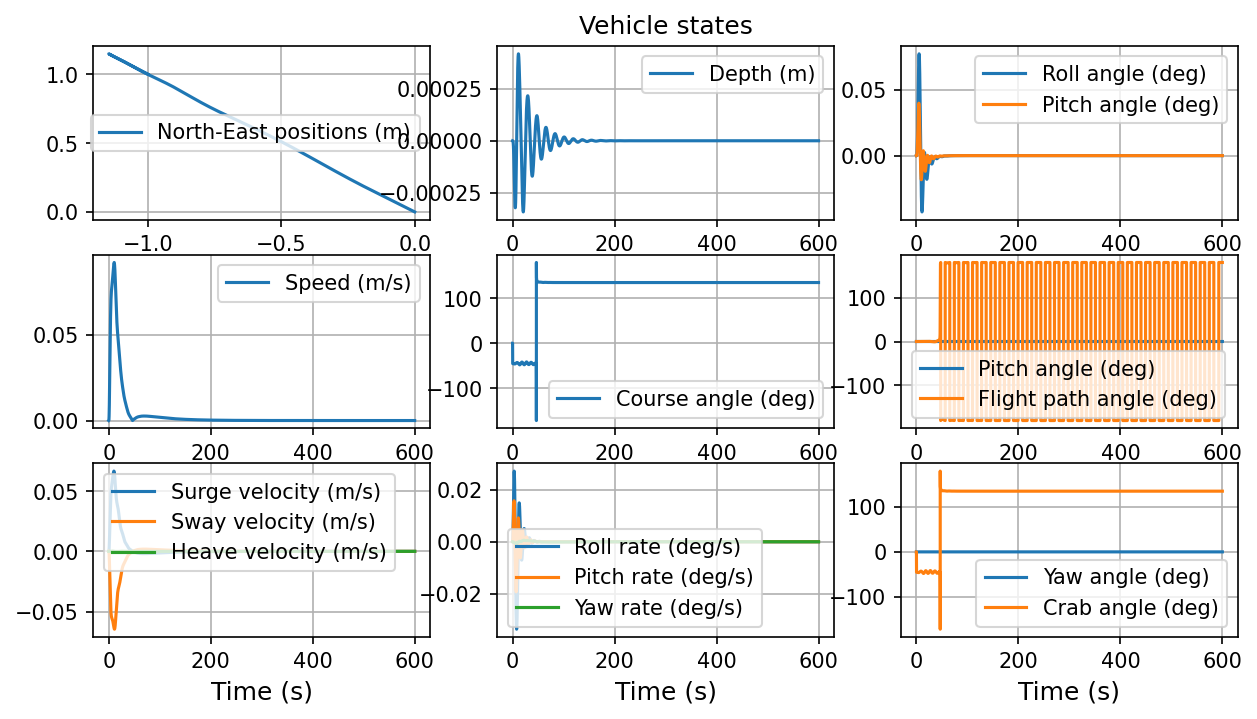

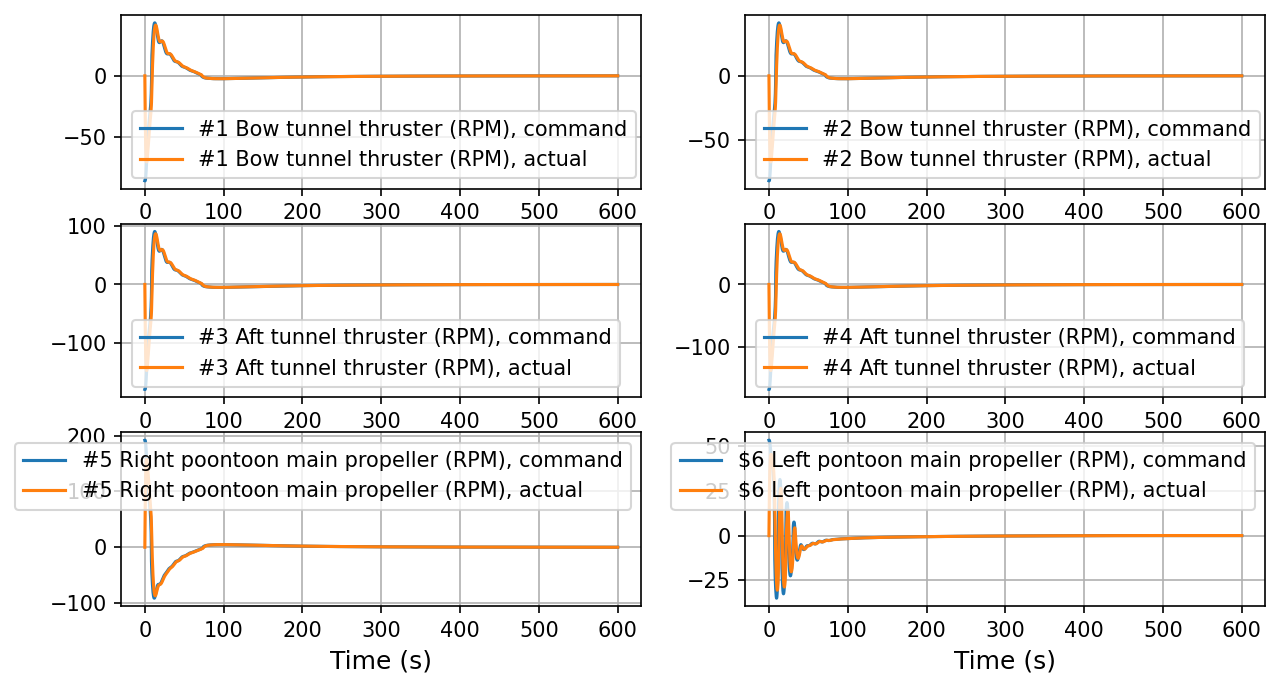

In [103]:
plotVehicleStates(simTime, simData, 1)
plotControls(simTime, simData, vehicle, 2)

In [104]:
numDataPoints = 5                 # number of 3D data points
FPS = 10                            # frames per second (animated GIF)
filename = '3D_animation.gif'       # data file for animated GIF
browser = 'safari'

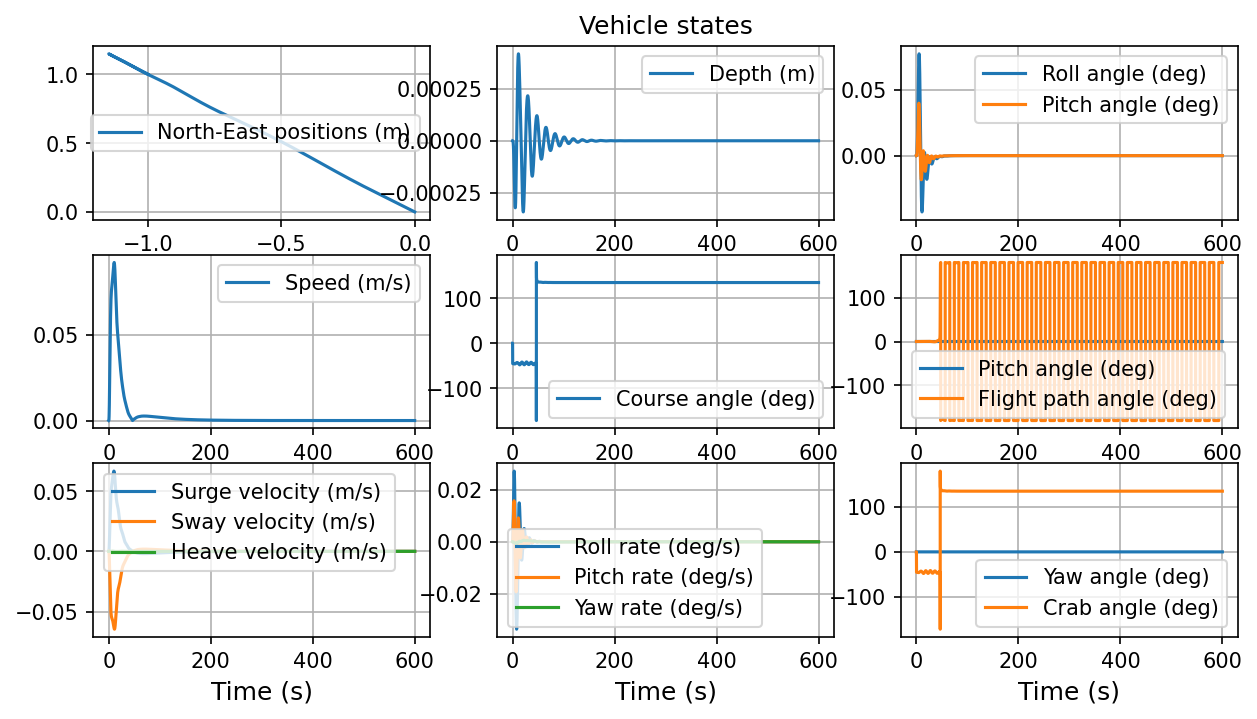

In [105]:
plotVehicleStates(simTime, simData, 3)

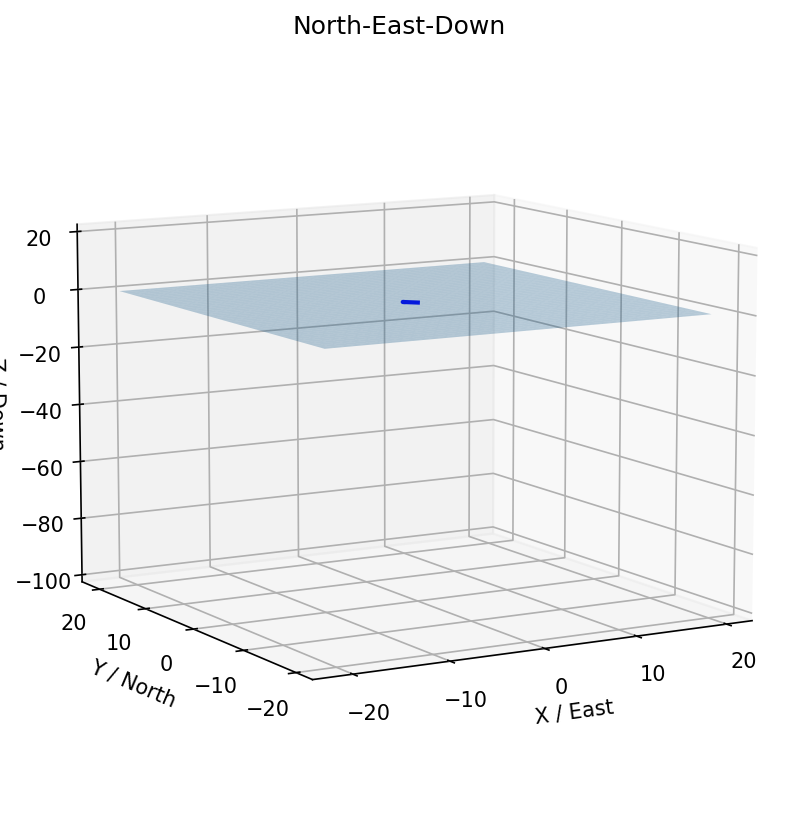

In [106]:
plot3D(simData, numDataPoints, FPS, filename, 3)

In [107]:
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

In [108]:
class MyTime:
    def __init__(self):
        self.my_t = 0
        self.v_m = np.array([0,0,0,0,0,0]).astype(np.float64)
        self.progression = [i for i in range(650)]
        self.wall_clock = datetime.now()
        self.x_ve = 0
        self.y_ve = 0
        self.z_ve = 0
        self.phi_ve = 0
        self.theta_ve = 0
        self.psi_ve = 0
        self.max_bending_strain = 0
        self.max_bending_strain1 = 0
        self.my_iter = 0

In [109]:
def inert(M, m, X):
    sum_=M
    ans=[]
    for i in range(len(X)-1,-1,-1):
        sum_+=m
        ans.append(np.array(sum_).copy())
    return np.array(ans)  

In [110]:
# V_rho=np.zeros(Jrho0.shape)
# np.fill_diagonal(V_rho, vessel_inertia)

In [111]:
# M_t=inert(vessel_mass*9.81,mp*9.81, x0)
# Jrho1=inert(V_rho, Jrho0, x0)

### Dynamics

In [112]:
def dynamic_func(t, Q, coefs, T, calibr):
    
    x,y,z=Q[0:N],Q[2*N:3*N],Q[4*N:5*N]
    dx,dy,dz=Q[1*N:2*N],Q[3*N:4*N],Q[5*N:6*N]
    φ,θ,ψ=Q[6*N:7*N],Q[8*N:9*N],Q[10*N:11*N]
    dφ,dθ,dψ=Q[7*N:8*N],Q[9*N:10*N],Q[11*N:12*N]
    
    idx = find_nearest(np.array(ans_t),  t)
    
    del_t = idx-T.my_t
    if del_t<0:
        idx=T.my_t
        
    x_ve = simData[:, 0][idx]
    y_ve = simData[:, 1][idx]
    z_ve = simData[:, 2][idx]
    phi_ve = ssa(simData[:, 3][idx])
    theta_ve = ssa(simData[:, 4][idx])
    psi_ve = ssa(simData[:, 5][idx])
    
    RET = Ret(φ,θ,ψ)

    vessel_movement = np.zeros(6)
    
    
    vessel_movement[0] = (x_ve - T.x_ve)
    vessel_movement[1] = (y_ve - T.y_ve)
    vessel_movement[2] = (z_ve - T.z_ve)
    vessel_movement[3] = (phi_ve - T.phi_ve)
    vessel_movement[4] = (theta_ve - T.theta_ve)
    vessel_movement[5] = (psi_ve - T.psi_ve)

    vessel_movement/=calibr
    

    fors, mom, angle = PipeForce(x, y, z, list(vessel_movement), coefs)
    
    Z0 = fors.squeeze()
    Z1 = d_s(ne, x, y, z, φ, θ, ψ).T
    Z2 = ne_hat(x, y, z, dx, dy, dz).T

    Z = (Z1 + Z2 - Z0)

############################################################
#     ddx,ddy, ddz = (Z/(M_t.reshape(-1, 1))).T
    ddx,ddy, ddz = (Z/Ws[0]).T    
############################################################
    
    C0 = np.einsum('ijk,ik->ij', Π(φ,θ,ψ), angle).squeeze()    
    C1 = d_s(me, φ, θ, ψ, φ, θ, ψ)
    C = (C1.T - C0)


    A0 = Jrho(RET,Jrho0)
#     A0 = Jrho(RET,Jrho1) 
    A_fin = np.einsum('ijk,ikr->ijr', A0, Π(φ,θ,ψ))
    

    B = np.einsum('ijk,ik->ij', Π(dφ,dθ,dψ), np.stack((dφ,dθ,dψ), axis=1))
    
    D = w_e(φ,θ,ψ,dφ,dθ,dψ)
    
    G = np.cross(d_s(phi,x,y,z,φ, θ, ψ).T, ne(x, y, z, φ, θ, ψ))
    
    L = np.einsum('ijk,ik->ij',RET, (DR@D.T).T) 

    H = np.cross(D, np.einsum('ijk,ik->ij', A0, D))
    

#############################################
    ddφ,ddθ,ddψ = np.linalg.solve(A_fin, (C + G - L - H - np.einsum('ijk,ik->ij', A0, B))).T
#############################################

    T.my_t=idx
    T.x_ve=x_ve
    T.y_ve=y_ve
    T.z_ve=z_ve
    T.phi_ve = phi_ve
    T.theta_ve = theta_ve
    T.psi_ve = psi_ve

    if t>T.progression[0]:
        T.progression.pop(0)
        print('Physical time: ', t, ' Iteration wall clock time: ', datetime.now() - T.wall_clock )
        T.wall_clock = datetime.now()   
        
        
    nz = np.linalg.norm(ddz)
    ddz = ddz / nz  
    
    ans=np.concatenate([dx, ddx, 
                        dy, ddy, 
                        dz, ddz, 
                        dφ, ddφ, 
                        dθ, ddθ, 
                        dψ, ddψ
                       ], axis=0)
   
   
    ax=np.max(np.einsum('ijk,ik->ij',np.linalg.inv(RET),ne(x, y, z, φ, θ, ψ)))/(mp*9.81*h)
    W = 3.14*(d0**4-dI**4)/(32*d0)
    T.max_bending_strain=max(T.max_bending_strain,(ax*12/W)/E)
    
    ben=np.max(np.einsum('ijk,ik->ij',np.linalg.inv(RET), me(φ, θ, ψ, φ, θ, ψ)))/(mp*9.81*1**2)
    T.max_bending_strain1=max(T.max_bending_strain1,(ben/W)/E)
    
    T.my_iter+=1
    
    return ans

In [113]:
T_ = MyTime()

# initial conditions
q0[6*N:7*N], q0[8*N:9*N], q0[10*N:11*N] = (np.array([0.01 for i in range(N)]),
                                          np.array([0.000001 for i in range(N)]),
                                          np.array([0.001257*i/N for i in range(N)]))

In [114]:
startTime1 = datetime.now()
us_=solve_ivp(dynamic_func,
             tspan,
             q0,
             args=(coefs, T_, vessel_motion_calibration_coefficient,))
print(datetime.now() - startTime1)

Physical time:  6.02338632167274e-07  Iteration wall clock time:  0:00:00.042483
Physical time:  1.0057298485158144  Iteration wall clock time:  0:00:01.655627
Physical time:  2.001979677404559  Iteration wall clock time:  0:00:01.077019
Physical time:  3.003345591329297  Iteration wall clock time:  0:00:01.396537
Physical time:  4.03811780196004  Iteration wall clock time:  0:00:00.903815
Physical time:  5.031770569237814  Iteration wall clock time:  0:00:00.766700
Physical time:  6.022821661669806  Iteration wall clock time:  0:00:01.253980
Physical time:  7.053722248808748  Iteration wall clock time:  0:00:00.856844
Physical time:  8.007025592082256  Iteration wall clock time:  0:00:00.976048
Physical time:  9.000933456366813  Iteration wall clock time:  0:00:00.709472
Physical time:  10.00026102071678  Iteration wall clock time:  0:00:00.761422
Physical time:  11.0146795676136  Iteration wall clock time:  0:00:00.891959
Physical time:  12.003517010914406  Iteration wall clock time:

In [115]:
# max bending strain
T_.max_bending_strain*mp*9.81*h

0.16094440422790374

In [116]:
T_.max_bending_strain1*mp*9.81*1**2

1.2305355305562433

In [117]:
# axial tension
W = 3.14*(d0**4-dI**4)/(32*d0)
T_.max_bending_strain*mp*9.81*h*W*E/12

10899369.587300561

### Results

In [118]:
fin=us_

In [119]:
fin

  message: The solver successfully reached the end of the integration interval.
  success: True
   status: 0
        t: [ 0.000e+00  6.023e-05 ...  4.994e+01  5.000e+01]
        y: [[ 0.000e+00  6.803e-26 ...  4.690e-04  4.702e-04]
            [ 2.326e+01  2.326e+01 ...  2.256e+01  2.256e+01]
            ...
            [ 0.000e+00 -1.171e-18 ... -2.135e-13 -2.188e-13]
            [ 0.000e+00 -2.720e-18 ... -5.090e-14 -4.933e-14]]
      sol: None
 t_events: None
 y_events: None
     nfev: 3356
     njev: 0
      nlu: 0

In [120]:
t=fin.t

In [121]:
fin=fin.y.T

In [122]:
t.shape, fin.shape

((428,), (428, 144))

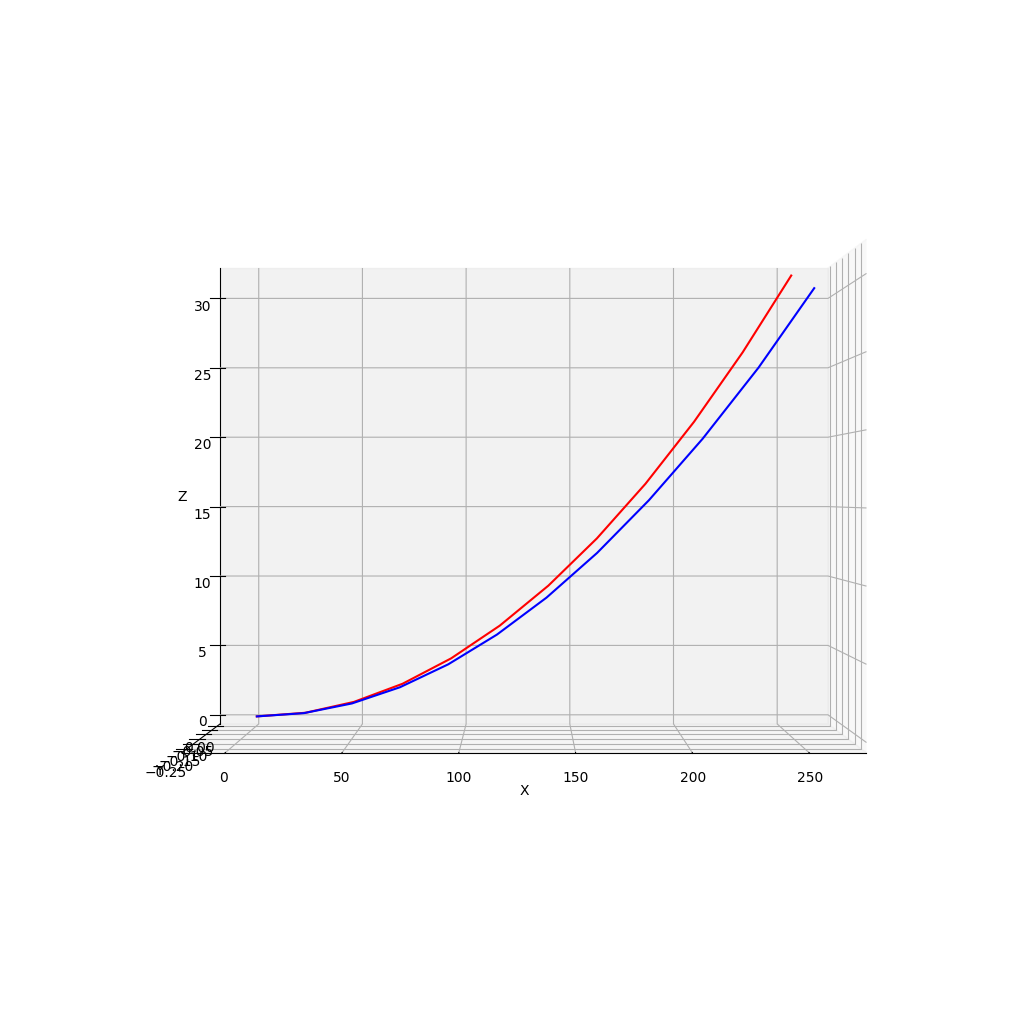

In [123]:
fig=plt.figure(figsize=(13,13))
ax = fig.add_subplot(projection = '3d')

X0=fin[0,[i for i in range(0,N)]]
Y0=fin[0,[i for i in range(2*N,3*N)]]
Z0=fin[0,[i for i in range(4*N,5*N)]]

j=-1
X=fin[j,[i for i in range(0,N)]]
Y=fin[j,[i for i in range(2*N,3*N)]]
Z=fin[j,[i for i in range(4*N,5*N)]]

num_true_pts = 200
tck, u = interpolate.splprep([X,Y,Z], s=2)
u_fine = np.linspace(0,1,num_true_pts)
x_fine, y_fine, z_fine = interpolate.splev(u_fine, tck)

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.plot(X0,Y0,Z0, color='r')
ax.plot(X,Y,Z, color='b')
# ax.plot(x_fine, y_fine, z_fine, color='b')
# ax.view_init(-45,-45)
# ax.view_init(-30,-30)
ax.view_init(0,-90)
plt.show()

In [124]:
X,Y,Z

(array([4.70216444e-04, 2.25594229e+01, 4.56906927e+01, 6.88660618e+01,
        9.20312443e+01, 1.15194042e+02, 1.38407332e+02, 1.61570405e+02,
        1.84654744e+02, 2.07888065e+02, 2.31094786e+02, 2.53130871e+02]),
 array([ 4.70174286e-08, -1.07043163e-04, -5.00060586e-03, -1.47526402e-02,
        -2.93582740e-02, -4.88143246e-02, -7.31501839e-02, -1.02315488e-01,
        -1.36277437e-01, -1.75202218e-01, -2.18972656e-01, -2.66351231e-01]),
 array([-1.69719482e-03,  2.34236922e-01,  9.53350881e-01,  2.16060501e+00,
         3.85493132e+00,  6.03077525e+00,  8.69425386e+00,  1.18453436e+01,
         1.54704776e+01,  1.95942565e+01,  2.42045608e+01,  2.91622664e+01]))

In [125]:
X0,Y0,Z0

(array([  0.        ,  23.2590084 ,  46.51801679,  69.77702519,
         93.03603358, 116.29504198, 139.55405037, 162.81305877,
        186.07206716, 209.33107556, 232.59008395, 255.84909235]),
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 array([ 0.        ,  0.25932181,  1.03741619,  2.33467001,  4.15172827,
         6.48949443,  9.34913084, 12.73205933, 16.63996193, 21.07478168,
        26.03872359, 31.53425578]))

In [126]:
us=fin.T

In [127]:
us.shape

(144, 428)

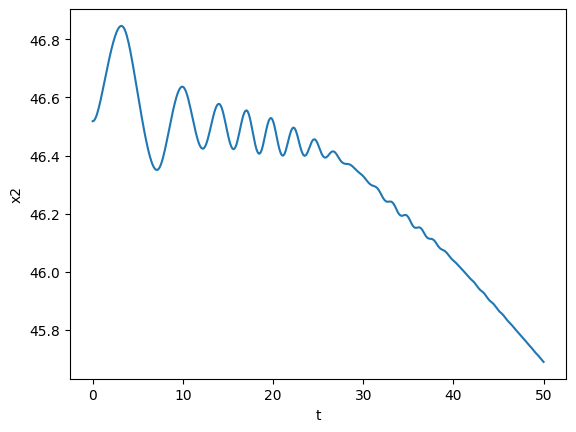

In [128]:
plt.plot(t,us.T[:,2],'-')
plt.xlabel('t')
plt.ylabel('x2')
plt.show()

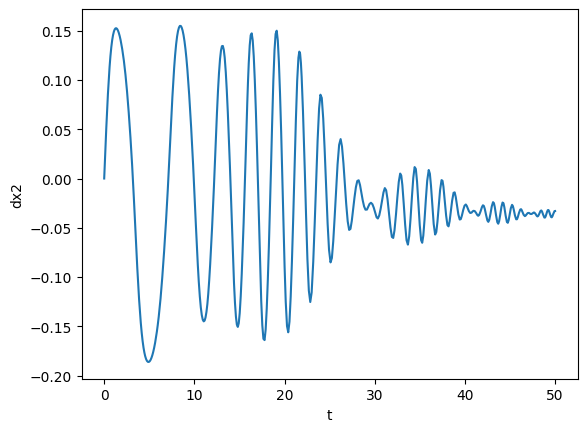

In [129]:
plt.plot(t,us.T[:,N+2] ,'-')
plt.xlabel('t')
plt.ylabel('dx2')
plt.show()

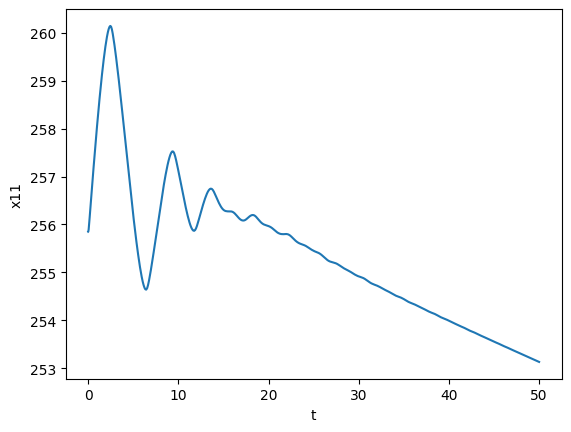

In [130]:
plt.plot(t,us.T[:,N-1] ,'-')
plt.xlabel('t')
plt.ylabel('x{}'.format(N-1))
plt.show()

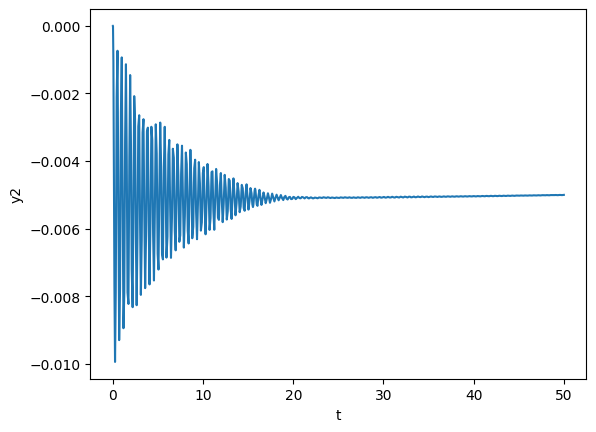

In [131]:
plt.plot(t,us.T[:,2*N +2] ,'-')
plt.xlabel('t')
plt.ylabel('y2')
plt.show()

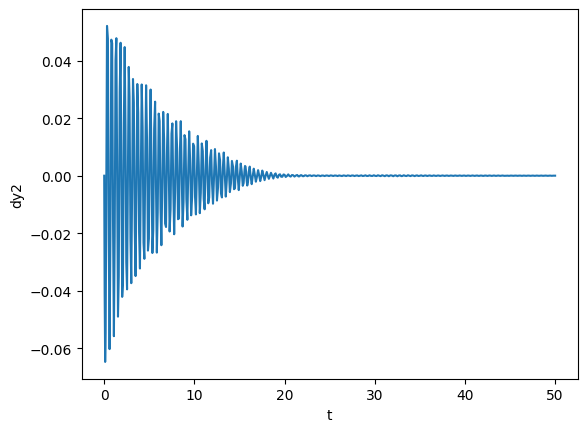

In [132]:
plt.plot(t,us.T[:,3*N+2] ,'-')
plt.xlabel('t')
plt.ylabel('dy2')
plt.show()

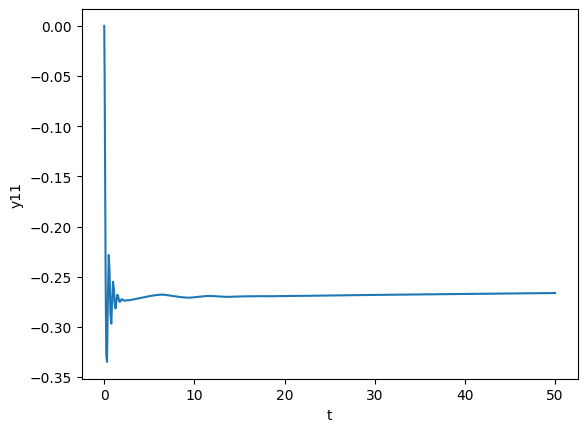

In [133]:
plt.plot(t,us.T[:,2*N+(N-1)] ,'-')
plt.xlabel('t')
plt.ylabel('y{}'.format(N-1))
plt.show()

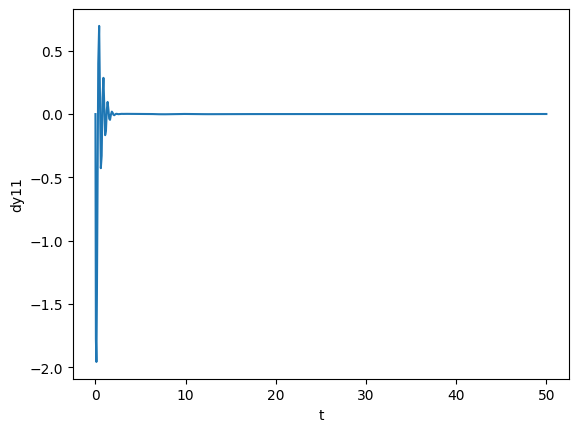

In [134]:
plt.plot(t,us.T[:,3*N+(N-1)] ,'-')
plt.xlabel('t')
plt.ylabel('dy{}'.format(N-1))
plt.show()

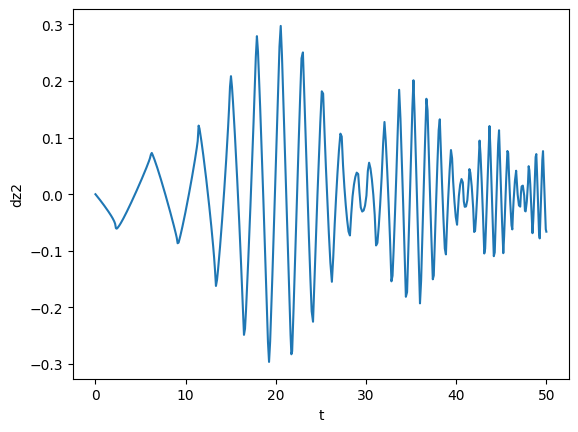

In [135]:
plt.plot(t,us.T[:,5*N+2] ,'-')
plt.xlabel('t')
plt.ylabel('dz2')
plt.show()

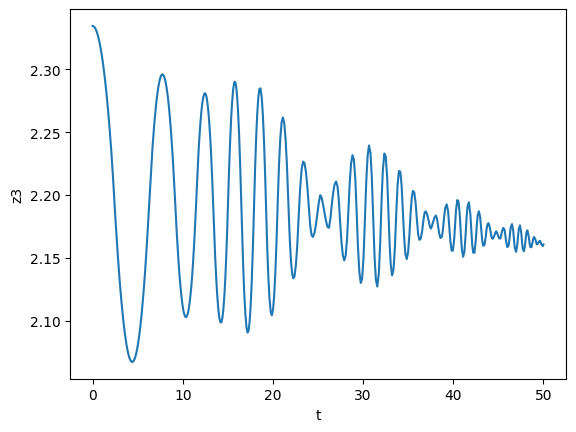

In [136]:
plt.plot(t,us.T[:,4*N+3] ,'-')
plt.xlabel('t')
plt.ylabel('z3')
plt.show()

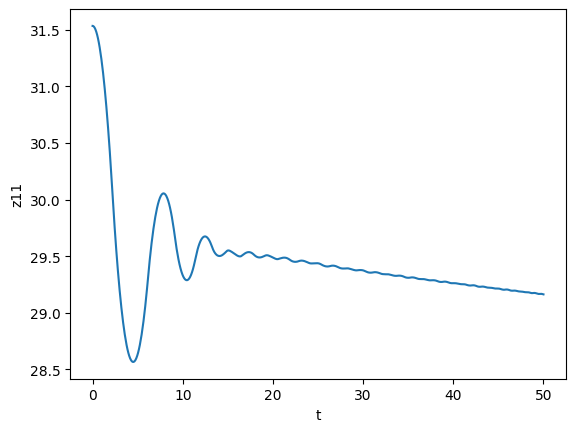

In [137]:
plt.plot(t,us.T[:,4*N + (N-1)] ,'-')
plt.xlabel('t')
plt.ylabel('z{}'.format(N-1))
plt.show()

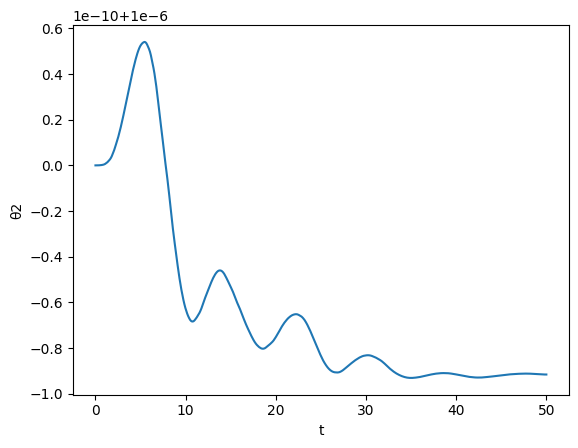

In [138]:
plt.plot(t,us.T[:,8*N+2],'-')
plt.xlabel('t')
plt.ylabel('θ2')
plt.show()

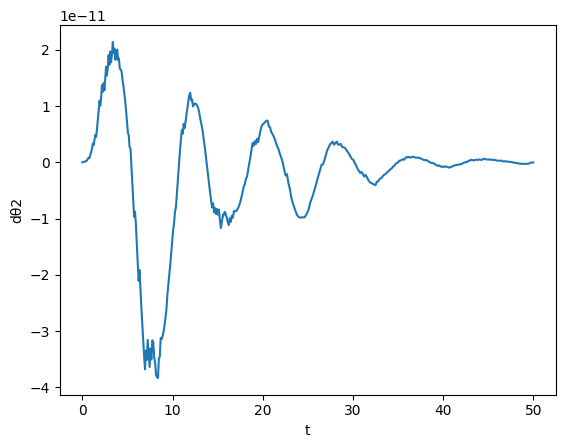

In [139]:
plt.plot(t,us.T[:,9*N+2] ,'-')
plt.xlabel('t')
plt.ylabel('dθ2')
plt.show()

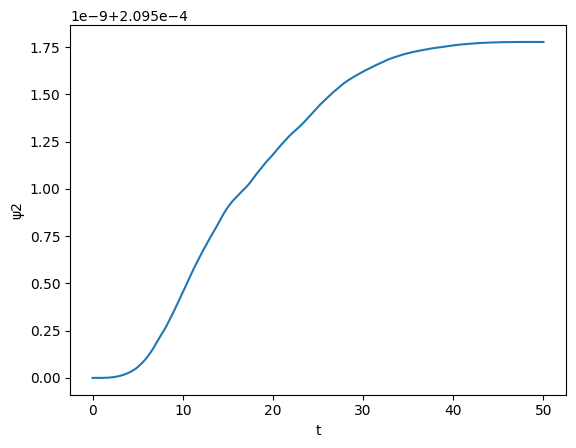

In [140]:
plt.plot(t,us.T[:,10*N+2],'-')
plt.xlabel('t')
plt.ylabel('ψ2')
plt.show()

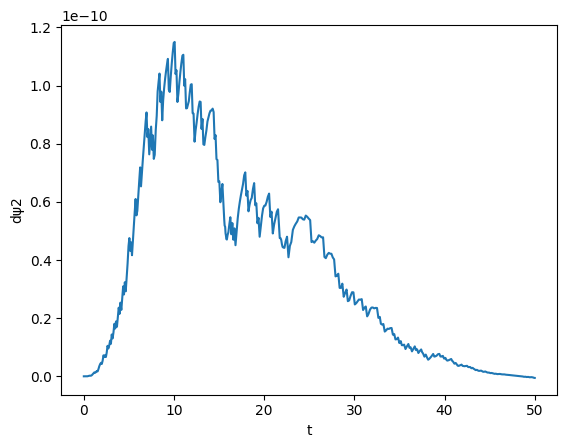

In [141]:
plt.plot(t,us.T[:,11*N+2] ,'-')
plt.xlabel('t')
plt.ylabel('dψ2')
plt.show()

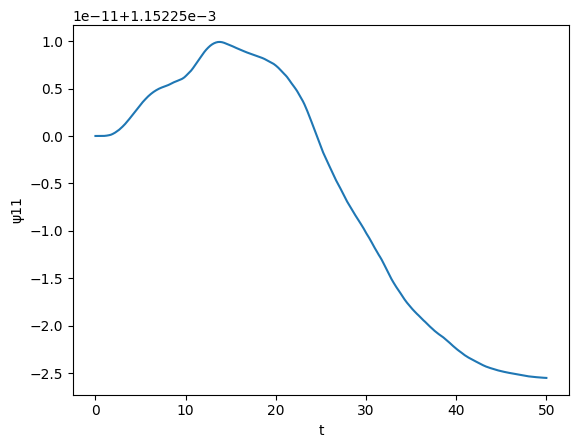

In [142]:
plt.plot(t,us.T[:,10*N + (N-1)] ,'-')
plt.xlabel('t')
plt.ylabel('ψ{}'.format(N-1))
plt.show()